# Brain MRI Images for Brain Tumor Detection Dataset
https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import glob
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import sys
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Reading the images

In [2]:
tumor = []
healthy = []
patterns = ['./brain_tumor_dataset/yes/*.jpg', './brain_tumor_dataset/yes/*.JPG']

# Loop over the patterns and append images to the tumor list
for pattern in patterns:
    for file in glob.iglob(pattern):
        image = cv2.imread(file)
        image = cv2.resize(image, (128, 128))
        b, g, r = cv2.split(image)
        image = cv2.merge([r, g, b])
        tumor.append(image)
print("Length of tumor images",len(tumor))

patterns = ['./brain_tumor_dataset/no/*.jpg', './brain_tumor_dataset/no/*.JPG', './brain_tumor_dataset/no/*.jpeg']
for pattern in patterns:
    for file in glob.iglob(pattern):
        image = cv2.imread(file)
        image = cv2.resize(image, (128,128)) 
        b, g, r = cv2.split(image)
        image = cv2.merge([r, g, b])
        healthy.append(image)
print("Length of healthy images",len(healthy))

Length of tumor images 154
Length of healthy images 97


In [3]:
healthy = np.array(healthy)
tumor = np.array(tumor)
all_images = np.concatenate((healthy, tumor))
print(healthy.shape)
print(tumor.shape)
print(all_images.shape)

(97, 128, 128, 3)
(154, 128, 128, 3)
(251, 128, 128, 3)


# Visualizing Brain MRI Images

In [4]:
def plot_random(healthy, tumor, num=5):
    healthy_images = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_images = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title("Healthy Images")
        plt.imshow(healthy_images[i])

    plt.figure(figsize=(16,8))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title("Tumor Images")
        plt.imshow(tumor_images[i])

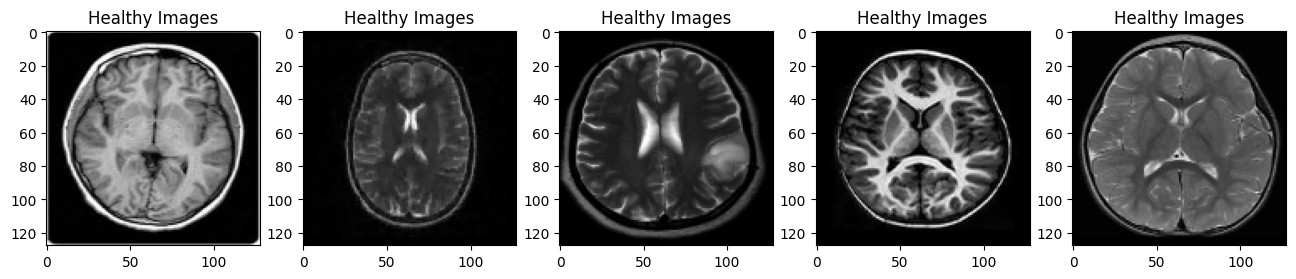

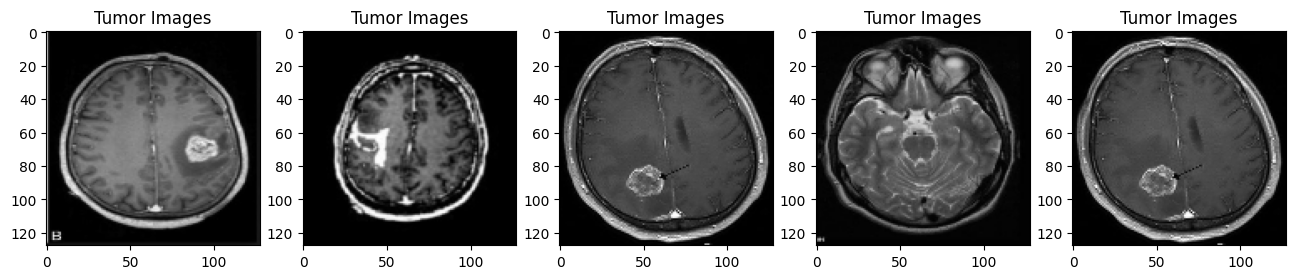

In [5]:
plot_random(healthy, tumor)

# MRI Dataset Class

In [10]:
class MRI(Dataset):
    def __init__(self):
        tumor = []
        healthy = []
        patterns = ['./brain_tumor_dataset/yes/*.jpg', './brain_tumor_dataset/yes/*.JPG']
        
        # Loop over the patterns and append images to the tumor list
        for pattern in patterns:
            for file in glob.iglob(pattern):
                image = cv2.imread(file)
                image = cv2.resize(image, (128, 128))
                b, g, r = cv2.split(image)
                image = cv2.merge([r, g, b])
                image = image.reshape((image.shape[2],image.shape[0],image.shape[1]))
                tumor.append(image)
        #print("Length of tumor images",len(tumor))
        
        patterns = ['./brain_tumor_dataset/no/*.jpg', './brain_tumor_dataset/no/*.JPG', './brain_tumor_dataset/no/*.jpeg']
        for pattern in patterns:
            for file in glob.iglob(pattern):
                image = cv2.imread(file)
                image = cv2.resize(image, (128,128)) 
                b, g, r = cv2.split(image)
                image = cv2.merge([r, g, b])
                image = image.reshape((image.shape[2],image.shape[0],image.shape[1]))
                healthy.append(image)
        #print("Length of healthy images",len(healthy))

        # images
        healthy_images = np.array(healthy, dtype=np.float32)
        tumor_images = np.array(tumor, dtype=np.float32)

        # labels
        tumor_label = np.ones(tumor_images.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy_images.shape[0], dtype=np.float32)
        
        # Concatenate
        self.images = np.concatenate((tumor_images, healthy_images), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __getitem__(self, index):
        sample = {'image': self.images[index], 'label':self.labels[index]}
        return sample
        
    def __len__(self):
        return self.images.shape[0]

    def normalize(self):
        self.images = self.images/255.0

In [11]:
mri_dataset = MRI()
mri_dataset.normalize()

In [12]:
mri_dataset.images[1].shape

(3, 128, 128)

# DataLoader

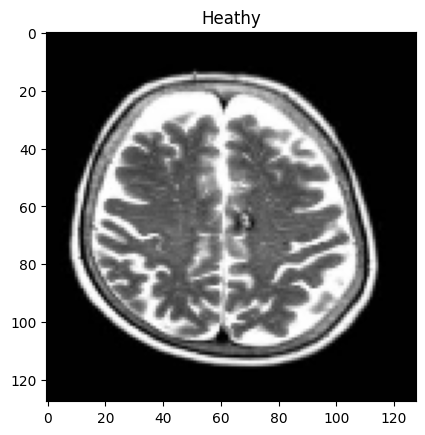

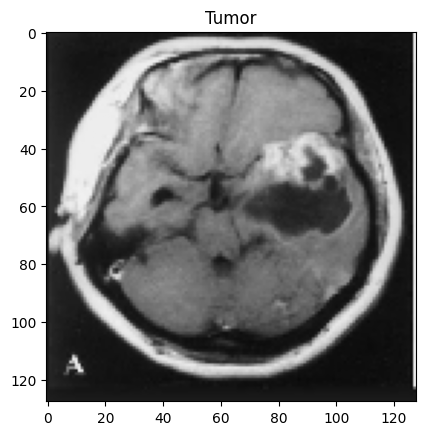

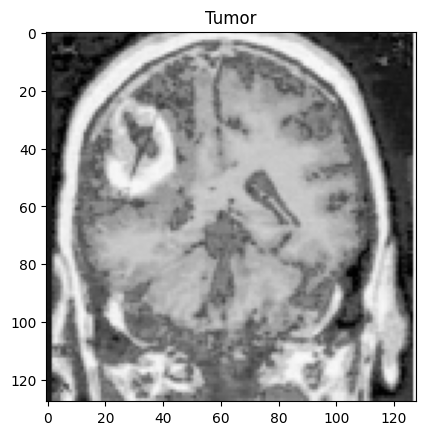

In [13]:
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
for i, sample in enumerate(dataloader):

    for j in range(sample['image'].shape[0]):
        #print(sample['image'][j].shape)
        img = sample['image'][j].squeeze()  
        #print(img.shape)
        img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
        #print(img.shape)
        plt.title(names[sample['label'][j].item()])
        plt.imshow(img)
        plt.show()
        if j==2:
            break
    
    if i == 0: 
        break

# Model

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x   

# Training

In [15]:
train_size = int(0.8 * len(mri_dataset)) 
val_size = len(mri_dataset) - train_size 
train_dataset, val_dataset = random_split(mri_dataset, [train_size, val_size])
print(len(train_dataset))
print(len(val_dataset))
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
print(len(train_loader))
print(len(val_loader))

200
51
25
7


In [18]:
eta = 0.0001
EPOCH = 400
device = torch.device('cuda:0')
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [19]:
for epoch in range(1, EPOCH):
    losses=[]
    for batch in train_loader:
        optimizer.zero_grad()
        image = batch['image'].to(device)
        label = batch['label'].to(device)
        y_pred = model(image)
        error = nn.BCELoss()
        loss = torch.sum(error(y_pred.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.617922
Train Epoch: 20	Loss: 0.555542
Train Epoch: 30	Loss: 0.518848
Train Epoch: 40	Loss: 0.482556
Train Epoch: 50	Loss: 0.460933
Train Epoch: 60	Loss: 0.441653
Train Epoch: 70	Loss: 0.419941
Train Epoch: 80	Loss: 0.384791
Train Epoch: 90	Loss: 0.351003
Train Epoch: 100	Loss: 0.322352
Train Epoch: 110	Loss: 0.288572
Train Epoch: 120	Loss: 0.257794
Train Epoch: 130	Loss: 0.228300
Train Epoch: 140	Loss: 0.201223
Train Epoch: 150	Loss: 0.152933
Train Epoch: 160	Loss: 0.136665
Train Epoch: 170	Loss: 0.087864
Train Epoch: 180	Loss: 0.067998
Train Epoch: 190	Loss: 0.042584
Train Epoch: 200	Loss: 0.031043
Train Epoch: 210	Loss: 0.022111
Train Epoch: 220	Loss: 0.016130
Train Epoch: 230	Loss: 0.011178
Train Epoch: 240	Loss: 0.008240
Train Epoch: 250	Loss: 0.005856
Train Epoch: 260	Loss: 0.004466
Train Epoch: 270	Loss: 0.003638
Train Epoch: 280	Loss: 0.002852
Train Epoch: 290	Loss: 0.002280
Train Epoch: 300	Loss: 0.001780
Train Epoch: 310	Loss: 0.001429
Train Epoch: 320	

# Evaluation

In [20]:
model.eval()
outputs=[]
y_true = []
with torch.no_grad():
    for batch in val_loader:
        image = batch['image'].to(device)
        label = batch['label'].to(device)
        
        y_pred = model(image)
        
        outputs.append(y_pred.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate(outputs, axis=0 )
y_true = np.concatenate(y_true, axis=0 )

In [21]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

accuracy_score(y_true, threshold(outputs))

0.7450980392156863

# Visualizing Accuracy

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

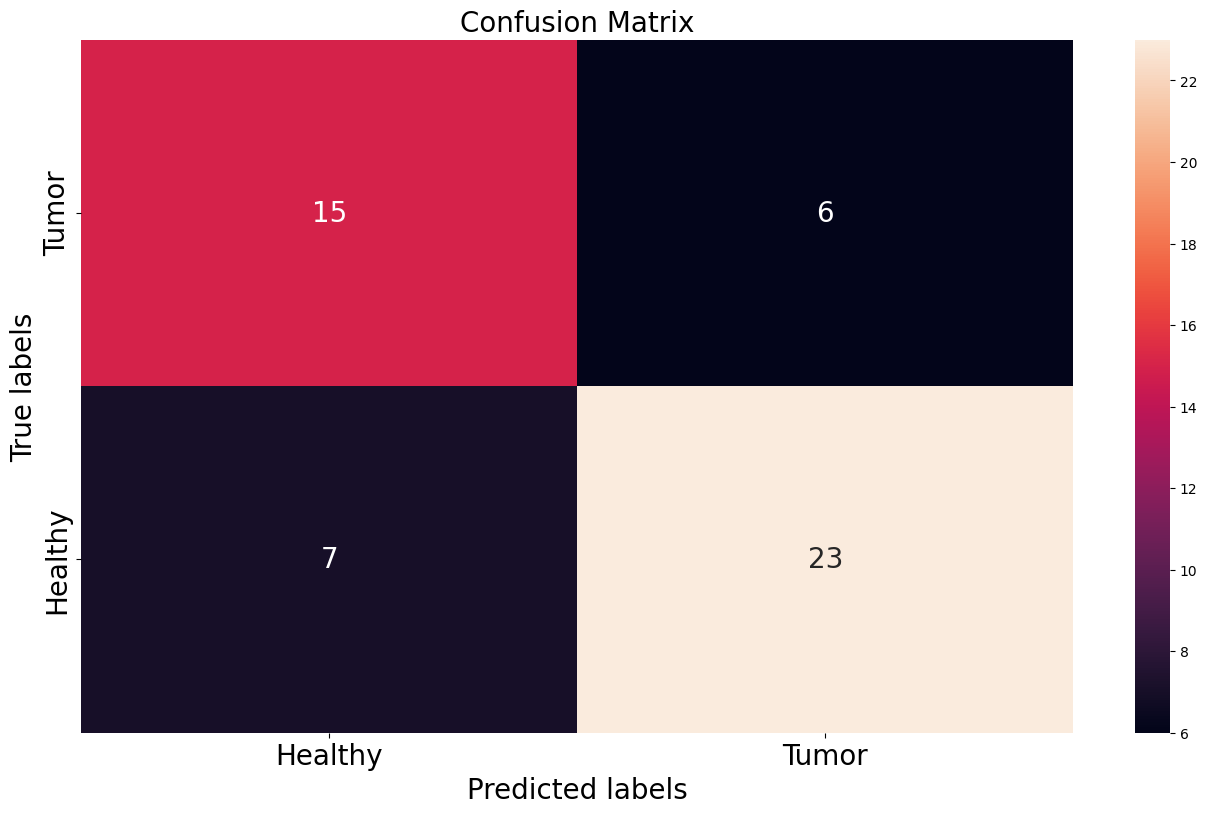

In [22]:
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)